In [9]:
import os
import re
import sys
import json
import codecs
import locale
import logging
import requests
import datetime as dt
from typing import Union, Optional, Tuple, List, cast

from matplotlib import pyplot as plt    # type: ignore  
import matplotlib.gridspec as gridspec  # type: ignore     

import tabula
from tabula import read_pdf

import pandas as pd
import numpy as np

In [10]:
#----------------------------------------------------------------
# Configurations section
#----------------------------------------------------------------

temp_content_dir = os.path.join(os.sep, 'tmp')
images_path = os.path.join("..","images")

now = dt.datetime.now()
sample_date = now.strftime("%d/%m/%Y")

locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')

ok_statuses = [200, 201, 202]
data_file_path = os.path.join("..","data")
tmp_data_file_path = os.path.join(os.sep,"tmp")

csv_data_file = os.path.join(data_file_path, "vaccinazioni.csv")
delivered_csv_data_file = os.path.join(data_file_path, "vaccini_consegnati.csv")



In [11]:
#----------------------------------------------------------------
# Import the procedures that download and transform the pdf file
# into a dataframe.
#----------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..','src'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ChartTools      import text_box    
from VacciniDownload import download_csv_file
from VacciniDownload import create_dataframe
from VacciniDownload import create_delivered_dataframe
from VacciniDownload import chart_vaccinations_male_female
from VacciniDownload import age_distribution
from VacciniDownload import company_distribution
from VacciniDownload import chart_vaccinations_fornitore
from VacciniDownload import plot_vaccinations_by_time
from VacciniDownload import plot_delivered_vaccines_quantity

from VacciniDownload import init_logger

init_logger('/tmp', "vaccini-notebook.log",log_level=logging.DEBUG, std_out_log_level=logging.ERROR)

/home/giovanni/code-personal/python/Virus/src


In [12]:
print(csv_data_file)
result = create_dataframe(data_file=csv_data_file)
if result.is_ok():
    df = result.value()
else:
    print(result.value())
    assert(False)
print("Last date {d}".format(d=df["data_somministrazione"].max()))    
(df.shape, df.dtypes)

../data/vaccinazioni.csv
Last date 2021-04-13 00:00:00


((34105, 20),
 data_somministrazione                         datetime64[ns]
 fornitore                                             object
 area                                                  object
 fascia_anagrafica                                     object
 sesso_maschile                                         int64
 sesso_femminile                                        int64
 categoria_operatori_sanitari_sociosanitari             int64
 categoria_personale_non_sanitario                      int64
 categoria_ospiti_rsa                                   int64
 categoria_over80                                       int64
 categoria_forze_armate                                 int64
 categoria_personale_scolastico                         int64
 categoria_altro                                        int64
 prima_dose                                             int64
 seconda_dose                                           int64
 codice_NUTS1                                          o

In [13]:
print(delivered_csv_data_file)
result = create_delivered_dataframe(data_file=delivered_csv_data_file)
if result.is_ok():
    df_delivered = result.value()
else:
    print(result.value())
    assert(False)
print("Last date {d}".format(d=df_delivered["data_consegna"].max()))    
(df_delivered.shape, df_delivered.dtypes)

../data/vaccini_consegnati.csv
Last date 2021-04-06 00:00:00


((768, 8),
 area                            object
 fornitore                       object
 numero_dosi                      int64
 data_consegna           datetime64[ns]
 codice_NUTS1                    object
 codice_NUTS2                    object
 codice_regione_ISTAT             int64
 nome_area                       object
 dtype: object)

In [14]:
df_delivered.head(5)

,area,fornitore,numero_dosi,data_consegna,codice_NUTS1,codice_NUTS2,codice_regione_ISTAT,nome_area
0,ABR,Pfizer/BioNTech,135,2020-12-27,ITF,ITF1,13,Abruzzo
1,ABR,Pfizer/BioNTech,7800,2020-12-30,ITF,ITF1,13,Abruzzo
2,ABR,Pfizer/BioNTech,3900,2021-01-05,ITF,ITF1,13,Abruzzo
3,ABR,Pfizer/BioNTech,3900,2021-01-07,ITF,ITF1,13,Abruzzo
4,ABR,Pfizer/BioNTech,3900,2021-01-11,ITF,ITF1,13,Abruzzo


/home/giovanni/code-personal/python/Virus/src/VacciniDownload.py:192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_del, rotation=80)


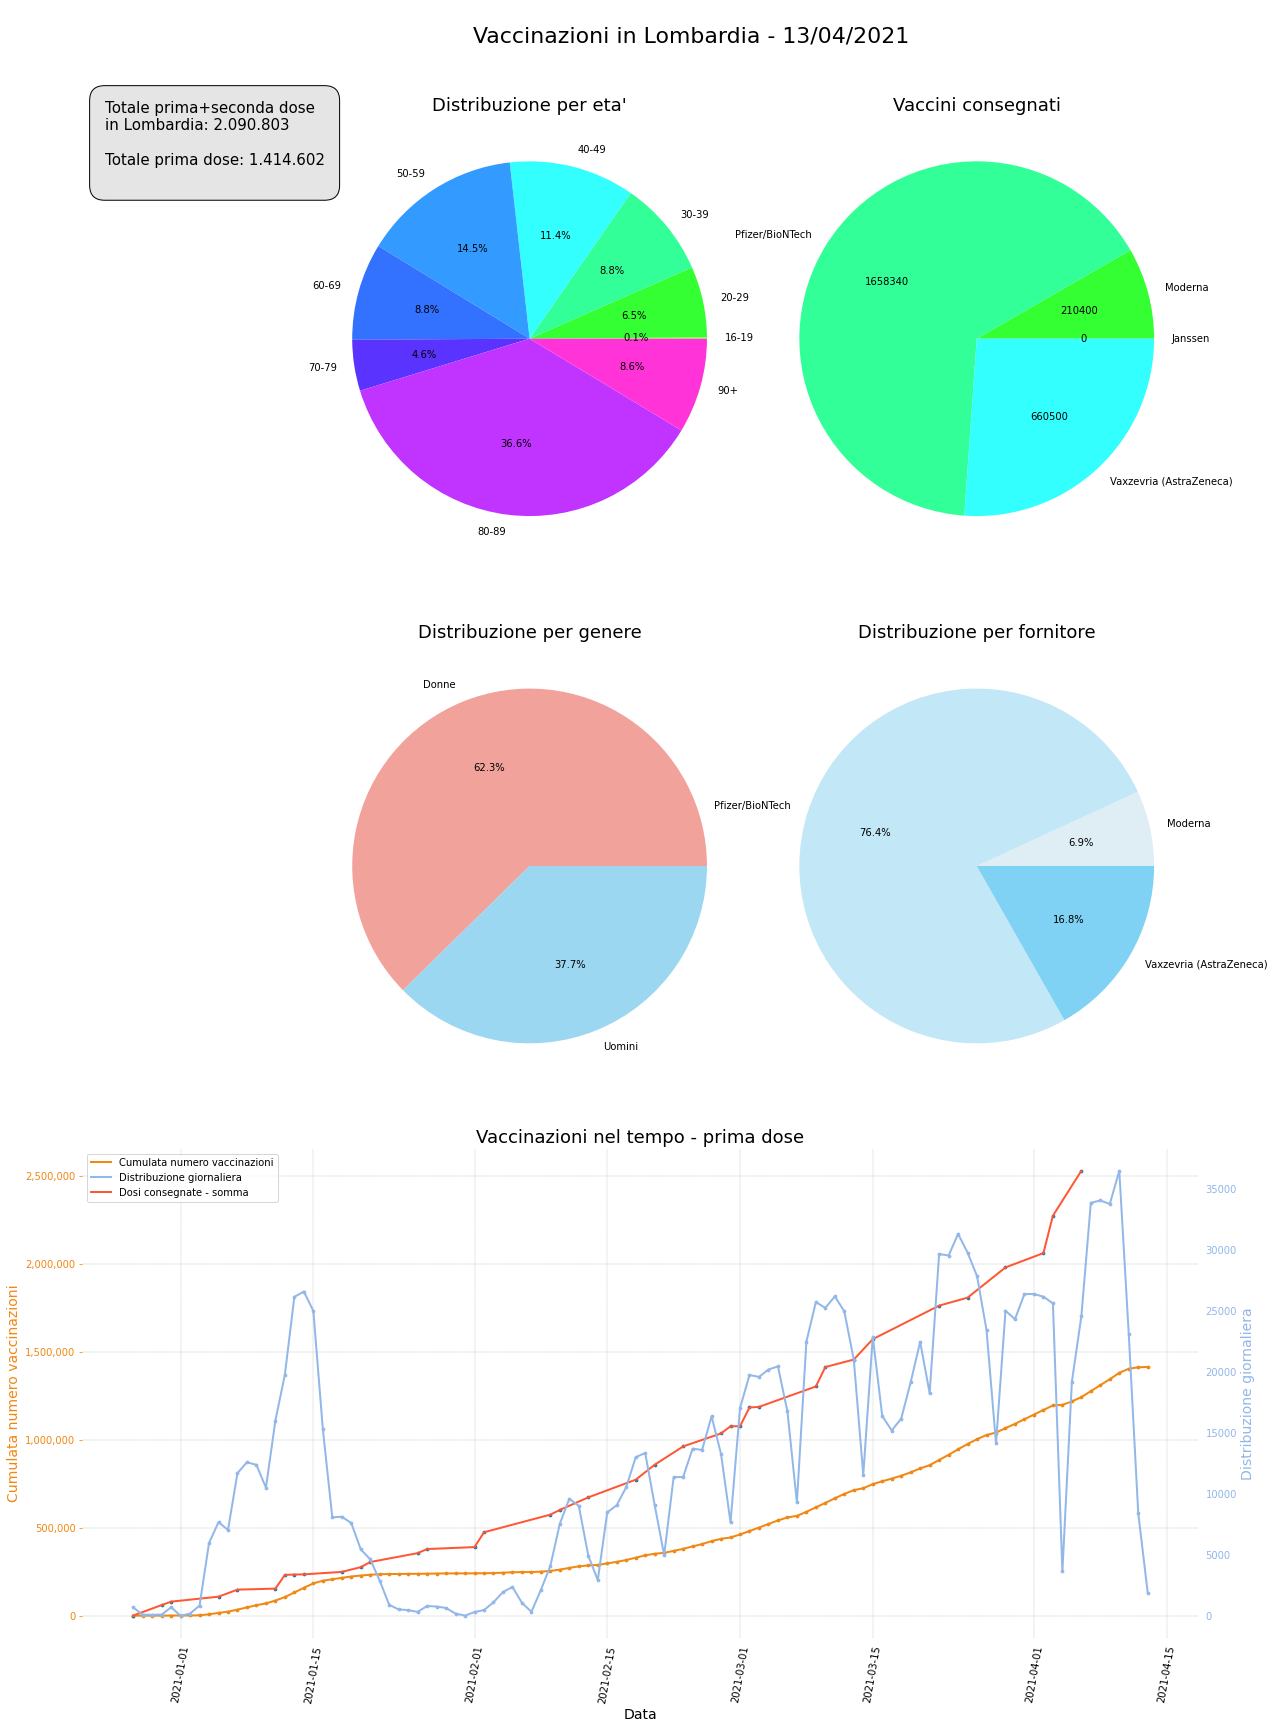

In [15]:
# --------------------------------------------------------------
# DATA SECTION
# --------------------------------------------------------------
regions = ["Lombardia","Lazio","Veneto","Sicilia",'Emilia-Romagna','Umbria']
region_name = regions[0]
mask_region = (df["nome_area"] == region_name)
df_region = df.loc[mask_region, ["data_somministrazione", "totali", 'fascia_anagrafica', "sesso_maschile","sesso_femminile", "fornitore", "prima_dose", "seconda_dose"]]

last_date = df["data_somministrazione"].max()
total_male = df_region["sesso_maschile"].sum()
total_female = df_region["sesso_femminile"].sum()
total = total_male + total_female
total_first_injection = df_region["prima_dose"].sum()

mask_region = (df_delivered["nome_area"] == region_name)
df_delivered_region = df_delivered.loc[mask_region, ["fornitore","numero_dosi","data_consegna"]]

# --------------------------------------------------------------
# CHART SECTION
# --------------------------------------------------------------
fig = plt.figure(figsize=(20, 30))
gs1 = gridspec.GridSpec(4, 3
                       ,figure=fig 
                       ,hspace=0.1
                       ,wspace=0.01
                       ,height_ratios=[1, 10, 10, 10]
                       ,width_ratios=[10, 20, 20])
ax = []

idx = 0
ax.append(fig.add_subplot(gs1[0,:]))
text_box(ax[idx], "Vaccinazioni in {re} - {dt}".format(dt=last_date.strftime('%d/%m/%Y')
                                                      ,re=region_name), x=0.35,y=0.4, fontsize=22)

idx += 1
ax.append(fig.add_subplot(gs1[1,0]))
text_box(ax[idx], """Totale prima+seconda dose\nin {r}: {t}

Totale prima dose: {pd}
"""
                  .format(r=region_name
                         ,pd=locale.format_string('%d', total_first_injection, grouping=True) 
                         ,t=locale.format_string('%d', total, grouping=True))
        ,x=0.1,y=0.9, fontsize=15,colors=["#e5e5e5", "#000000", "#000000"])

idx += 1
ax.append(fig.add_subplot(gs1[1,1]))
result = age_distribution(df_region, ax=ax[idx], gender="B")

idx += 1
ax.append(fig.add_subplot(gs1[1,2]))
result = company_distribution(df_delivered_region, ax=ax[idx])

idx += 1
ax.append(fig.add_subplot(gs1[2,1]))
result = chart_vaccinations_male_female(df_region, ax=ax[idx])

idx += 1
ax.append(fig.add_subplot(gs1[2,2]))
result = chart_vaccinations_fornitore(df_region, ax=ax[idx])

idx += 1
ax.append(fig.add_subplot(gs1[3,:]))
result = plot_vaccinations_by_time(df_region, df_delivered_region, ax=ax[idx])

output_format = "JPEG"
plt.savefig(os.path.join(images_path,"{prefix}-Vaccinazioni-{r}.{fmt}".format(fmt=output_format
                                                                            ,r=region_name 
                                                                            ,prefix=last_date.strftime('%Y%m%d')))
          ,format=output_format
          ,bbox_inches='tight'
          ,pad_inches=0.01)

In [16]:
regions = ["Lombardia","Lazio","Veneto","Sicilia",'Emilia-Romagna']
region_name = regions[0]

mask_region = (df_delivered["nome_area"] == region_name)
df_delivered_region = df_delivered.loc[mask_region, ["fornitore","numero_dosi","data_consegna"]]
df_delivered_region.sort_values(by="data_consegna", inplace=True)
by_date = df_delivered_region.groupby(["data_consegna"]).sum()
by_date.reset_index(level=0, inplace=True)
by_date["cumulata"] = by_date["numero_dosi"].cumsum()
by_date

,data_consegna,numero_dosi,cumulata
0,2020-12-27,1620,1620
1,2020-12-30,59475,61095
2,2020-12-31,19500,80595
3,2021-01-05,28275,108870
4,2021-01-07,39975,148845
5,2021-01-11,5850,154695
6,2021-01-12,78000,232695
7,2021-01-13,1950,234645
8,2021-01-14,975,235620
9,2021-01-18,14040,249660
